In [5]:
import features
import numpy as np
import utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import dataloader
import pitchspace
import visualization

dset = "beatles"
track_id = "1109" 

# RM-P002 , rwc_pop
# -> shows that the threshold for the hcdf is a crucial parameter
# -> F-min7 with a missing root note 

# RM-P006 Funky life, sevenths alphabet funktioniert hier überhaupt nicht
# RM-P027 interesting for No chord modeling
# RM-P010 Interessant weil liegender Ton mit hoher Energie, HCDF threshold
# RM-P035 -> chord change can be corrected with HCDF
# 0301 Hard days night, 0607 Michelle, 0702 Eleanor Rigby

dataset = dataloader.Dataloader(dset,"/home/max/ET-TI/Masterarbeit/chord-recognition/mirdata","none")
classifier = pitchspace.CPSS_Classifier(alphabet="sevenths")
audiopath, annotationpath = dataset[track_id] 
sig = utils.loadAudiofile(audiopath)
dcp = features.deepChroma(audiopath)
gt = utils.loadChordAnnotations(annotationpath)
chroma,pitchgram,pitchgram_cqt = features.crpChroma(sig,nCRP=33)
t_audio = utils.timeVector(len(sig),hop_length=1,sr=22050)
t_chroma = utils.timeVector(chroma.shape[1],hop_length=2048)

## load recognition result for track

filepath = "/home/max/ET-TI/Masterarbeit/chord-recognition/results/pitchspace.hdf5"
track_data,chromadata,ground_truth,est_majmin,est_sevenths = visualization.load_trackdata(filepath,track_id,dset)
print(track_data)

track(track_id='1109', name='09_-_You_Never_Give_Me_Your_Money', dataset='beatles', majmin_wscr=0.71, majmin_seg=0.87, majmin_f=0.78, sevenths_wscr=0.52, sevenths_seg=0.87, sevenths_f=0.65)


### How to find chord boundaries?

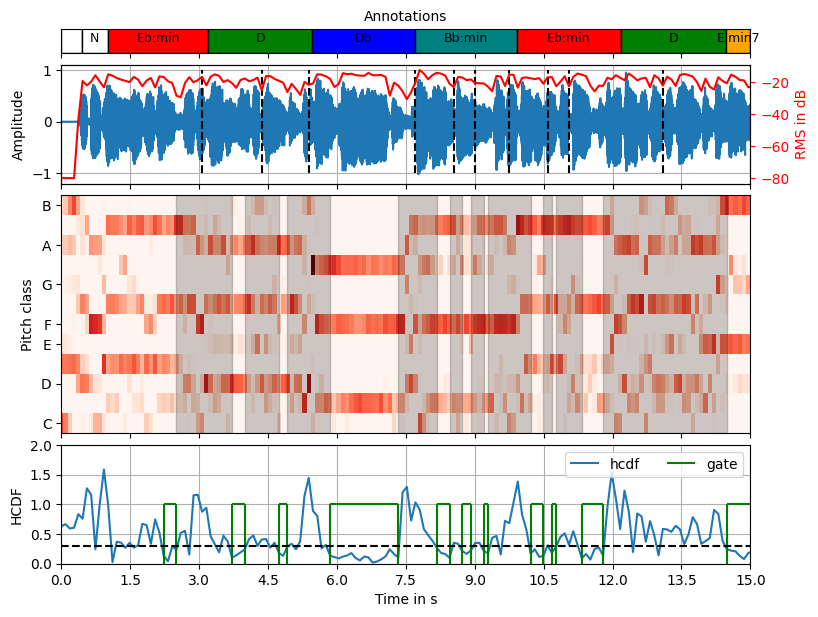

In [13]:
import itertools

rms = features.computeRMS(sig)
hcdf = pitchspace.computeHCDF(chroma,prefilter_length=3,use_cpss=False)

## thresholding
threshold = 0.3
min_distance = 1
gate = np.zeros_like(hcdf)
gate[hcdf < threshold] = 1
stable_regions = []
start_index = 0

for i, value in enumerate(gate):
    if value == 1:
        if start_index is None:
            start_index = i
    elif start_index is not None:
        # check if the interval is long enough
        if i - start_index > min_distance: 
            stable_regions.append((start_index, i-1))
        start_index = None
# check if last index is still ongoing
if start_index is not None:
    stable_regions.append((start_index, len(gate) - 1))

time_interval = (0,15)
fig,(ax0,ax1,ax2,ax3) = plt.subplots(4,1,height_ratios=(1,5,10,5),figsize=(8,6))
utils.plotChordAnnotations(ax0,gt[0],gt[1],time_interval)
ax0.set_title('Annotations',fontsize=10)
ax1.plot(t_audio,sig)
ax1.set_ylabel("Amplitude")
ax1.grid("on")
ax12 = ax1.twinx()
ax12.plot(t_chroma,rms,'-',color="r")
ax12.set_ylabel("RMS in dB", color='red')
ax12.tick_params('y', colors='red')
utils.plotChromagram(ax2,t_chroma,chroma,time_interval)
ax3.plot(t_chroma,hcdf)
for x,y in itertools.pairwise(stable_regions):
    x_i0,x_i1 = x 
    y_i0,y_i1 = y
    chord_change_index = (x_i1 + y_i0) // 2     # chord change in between stable regions
    ax1.vlines(t_chroma[chord_change_index],-1,1,'k',linestyle="--")
    rect = patches.Rectangle((t_chroma[x_i1],-0.5),t_chroma[y_i0] - t_chroma[x_i1],12,facecolor="k",alpha=0.1,edgecolor="k")
    ax2.add_patch(rect)
    ax2.add_artist(rect)
for indices in stable_regions:
    ax3.hlines(1,t_chroma[indices[0]],t_chroma[indices[1]],'green')
    ax3.vlines([t_chroma[indices[0]],t_chroma[indices[1]]],[0,0],[1,1],'green')
ax3.hlines(threshold,time_interval[0],time_interval[1],'k',linestyle="--")

ax3.set_ylabel("HCDF")
ax3.set_ylim(0,2)
ax3.set_xlim(time_interval)
ax3.grid("on")
xticks = np.linspace(time_interval[0],time_interval[1],num=11)
ax3.set_xticks(xticks)
ax3.set_xlabel("Time in s")
ax3.legend(["hcdf","gate"],loc=1,ncols=2)
ax0.set_yticks([])
for ax in (ax0,ax1,ax2):
    ax.set_xlim(time_interval)
    ax.set_xticks(xticks)
    ax.set_xticklabels([])
    ax.set_xlabel("")

fig.tight_layout(pad=0.1)
# fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/refined_harmonic_change.png")


### Refine estimation with CPSS 

check if the time gap between two unstable regions is larger than 400ms. </br>
if True then insert a "No chord" label into the  estimation, </br>
if False adjust the time intervals such that the chord transition is in between the two stable regions

In [14]:
def computeIntervalCategories(chroma):
    if chroma.shape[0] != 12:
        raise ValueError("invalid Chromagram shape!")
    ic = np.zeros((6, chroma.shape[1]), dtype=float)

    for i in range(6):
        rotated_chroma = np.roll(chroma, shift=i+1, axis=0)
        ic[i,:] = np.sum(chroma * rotated_chroma, axis=0)
    return ic

# compute correlation with template based approach
chroma_prefiltered = features.applyPrefilter(t_chroma,chroma,"median",prefilter_length=7)

correlation, labels = features.computeCorrelation(chroma_prefiltered,template_type="sevenths")
# enforce No chord until first stable region
correlation[:, :stable_regions[0][0]] = 0.0
correlation[-1, :stable_regions[0][0]] = 1.0
correlation_nochord = np.zeros_like(correlation)
correlation_nochord[-1,:] = 1.0

# classify stable regions witch tonal pitch space
for (i0, i1) in stable_regions:
    # find tonal center of stable regions with ~8 seconds context
    i_a = np.maximum(0,i0-40)
    i_b = np.minimum(t_chroma.shape[0],i1+40)
    chroma_regional = np.average(chroma_prefiltered[:, i_a:i_b],axis=1).reshape((12,1))
    ic_energy = np.zeros((12,))  
    for i in range(12):
        # neglect all chromabins that are not part of the diatonic circle -> key_related_chroma
        pitch_classes = np.roll([1,0,1,0,1,1,0,1,0,1,0,1],i)
        key_related_chroma = np.multiply(chroma_regional, np.reshape(pitch_classes, (12,1))) 
        ic_energy[i] = np.sum(computeIntervalCategories(key_related_chroma), axis=0)
    key_index = np.argmax(ic_energy)

    index = classifier.classify(np.median(chroma_prefiltered[:, i0:i1],axis=1),key_index)
    if index is not None:
        correlation[:, i0:i1] = 0.0
        correlation[index, i0:i1] = 1.0
        correlation_nochord[index, i0:i1] = 1.0

# decode estimation of stable regions
chord_sequence = [labels[i] for i in np.argmax(correlation_nochord,axis=0)] 
est_intervals_stable,est_labels_stable = utils.createChordIntervals(t_chroma,chord_sequence)

# viterbi smoothing
A = features.uniform_transition_matrix(0.2,len(labels)) # state transition probability matrix
B_O = correlation / (np.sum(correlation,axis=0) + np.finfo(float).eps) # likelyhood matrix -> quasi normalized inner product
C = np.ones((len(labels,))) * 1/len(labels)   # initial state probability matrix
correlation_smoothed,_,_,_ = features.viterbi_log_likelihood(A,C,B_O)  
chord_sequence = [labels[i] for i in np.argmax(correlation_smoothed,axis=0)] 
est_intervals,est_labels = utils.createChordIntervals(t_chroma,chord_sequence)


For every chord estimation find all overlapping intervals

----Sevenths----
cpss: (0.69, 0.83)
hmm: (0.76, 0.88)
----Majmin----
cpss: (0.83, 0.83)
hmm: (0.91, 0.88)


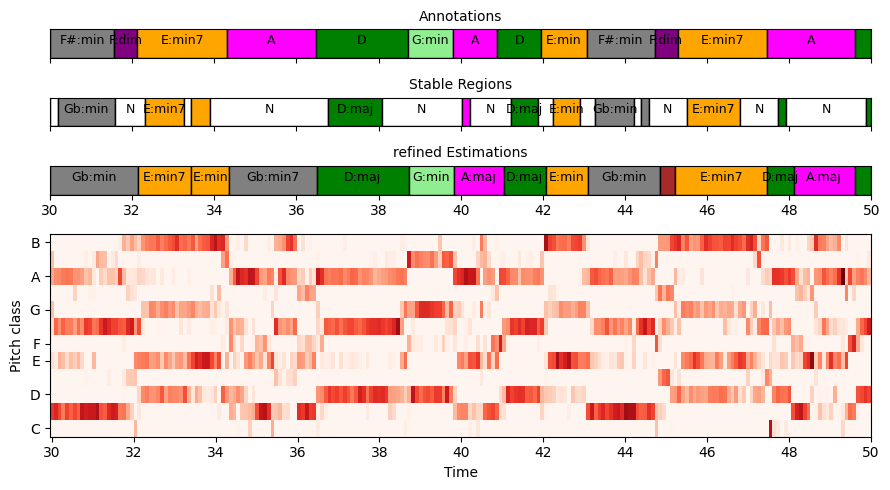

In [15]:
time_interval = (30,50)
xticks = np.linspace(time_interval[0],time_interval[1],11)
xticklabels = np.linspace(time_interval[0],time_interval[1],11,dtype=int)
fig,(ax0,ax1,ax2,ax3) = plt.subplots(4,1,height_ratios=(1,1,1,7),figsize=(9,5))
utils.plotChordAnnotations(ax0,gt[0],gt[1],time_interval)
ax0.set_title('Annotations',fontsize=10)
ax0.set_yticks([])
utils.plotChordAnnotations(ax1,est_intervals_stable,est_labels_stable,time_interval)
ax1.set_title('Stable Regions',fontsize=10)
ax1.set_yticks([])
utils.plotChordAnnotations(ax2,est_intervals,est_labels,time_interval)
ax2.set_title('refined Estimations',fontsize=10)
ax2.set_yticks([])
for ax in [ax0,ax1,ax2]:
    ax.set_xticks(xticks)
    ax.set_xticklabels([])
ax2.set_xticklabels(xticklabels)
utils.plotChromagram(ax3,t_chroma,chroma,time_interval)
ax3.set_xticks(xticks)
fig.tight_layout()

print("----Sevenths----")
x = utils.evaluateTranscription(est_intervals,est_labels,ground_truth[0],ground_truth[1],"sevenths")
print(f"cpss: {x}")
x = utils.evaluateTranscription(est_sevenths[0],est_sevenths[1],ground_truth[0],ground_truth[1],"sevenths")
print(f"hmm: {x}")

x = utils.evaluateTranscription(est_intervals,est_labels,ground_truth[0],ground_truth[1],"majmin")
print("----Majmin----")
print(f"cpss: {x}")
x = utils.evaluateTranscription(est_sevenths[0],est_sevenths[1],ground_truth[0],ground_truth[1],"majmin")
print(f"hmm: {x}")